# TWITTER SENTIMENT ANALYSIS PROJECT  
-  Twitter sentiment analysis project involves using natural language processing (NLP) and machine learning techniques to analyze and understand the sentiments expressed in tweets on the social media platform X. The primary objective of such a project is to determine whether tweets are positive, negative, or neutral, and to gain insights into public opinion or reactions about a particular topic, event, product, or brand.

- Then a model will building and observing how much accuracy our model classifiy the positive and negative words. 

This notebook prepared by Betul Ozkaldi 

##  Libraries

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re #regular expression library it is for textual data
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import scikitplot as skplt

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_curve,auc, classification_report,accuracy_score,\
                            f1_score, precision_score,recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV


## Import Data

In [146]:
df =pd.read_csv('C:/Users/btloz/JupyterNotes/Project/Sentiment/NLP_Twitter_Sentiments.csv')
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [148]:
df.shape

(31962, 3)

In [149]:
df['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

_**Classes:**_  
**0 :  Not Racist/ sexist/Positive**   
**1 :  Racist/ sexist/ Negative**

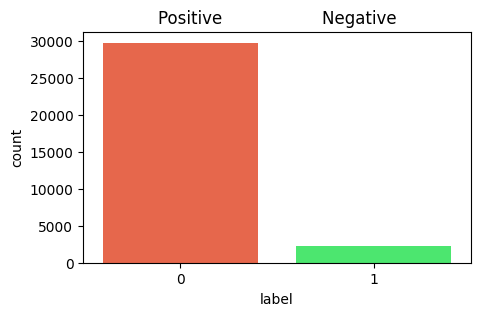

In [150]:
custom_palette = ["#FF5733", "#33FF61"]
plt.figure(figsize=(5,3))
plt.title('Positive                   Negative')
plt.xlabel('Label of Tweet')
plt.ylabel('Count of Tweets');
sns.countplot(x= df['label'], data= df, palette=custom_palette);

- Looks this is not equally distibuted labels.
- There is no missing data.

##  Cleaning Data

Let's clean the data before proceeding with any modeling tasks.I'll create new columns to observe the changes clearly.

In [151]:
#remove @user
remove_user   = lambda x: x.replace('@user','').strip()

In [152]:
df['tweet-2'] = df['tweet'].apply(lambda x: x.replace('@user','').strip())
df.head()

,id,label,tweet,tweet-2
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [153]:
# let's see some tweets
for tw in df['tweet-2'][:6]:
    print(tw)
    print('-'*50)

when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
--------------------------------------------------
thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
--------------------------------------------------
bihday your majesty
--------------------------------------------------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦
--------------------------------------------------
factsguide: society now    #motivation
--------------------------------------------------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
--------------------------------------------------


In [154]:
df['tweet-2'].isnull().sum()

0

**re.findall**   
- We need to get rid of numbers and symbols. Let's use regular expressions.

In [155]:
#keep only lowercase and upper case letters and #
df['tweet-3'] = df['tweet-2'].str.replace('[^a-zA-Z#]', ' ', regex=True)
df.head(8)

,id,label,tweet,tweet-2,tweet-3
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦,camping tomorrow danny
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...,the next school year is the year for exams ...


- Let's remove the words with **len<=3**. First, split the words and find the words which are less than 3 charachter then make a sentence again.

In [156]:
df['tweet-4']= df['tweet-3'].apply(lambda x:' '.join([i for i in x.split() if len(i)>3]))
df.head()

,id,label,tweet,tweet-2,tweet-3,tweet-4
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation,factsguide society #motivation


In [157]:
#Let's check our tweets
for i in df['tweet-4'][:6]:
    print(i)
    print('-'*100)

when father dysfunctional selfish drags kids into dysfunction #run
----------------------------------------------------------------------------------------------------
thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
----------------------------------------------------------------------------------------------------
bihday your majesty
----------------------------------------------------------------------------------------------------
#model love take with time
----------------------------------------------------------------------------------------------------
factsguide society #motivation
----------------------------------------------------------------------------------------------------
huge fare talking before they leave chaos disputes when they there #allshowandnogo
----------------------------------------------------------------------------------------------------


**Text Normalization**

## Tokenazition

In [158]:
#convert tokens (words are in a list)
df['tokens'] = df['tweet-4'].apply(lambda x: x.split())
df.head()

,id,label,tweet,tweet-2,tweet-3,tweet-4,tokens
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,when father dysfunctional selfish drags kids i...,"[when, father, dysfunctional, selfish, drags, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...,thanks #lyft credit cause they offer wheelchai...,"[thanks, #lyft, credit, cause, they, offer, wh..."
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty,bihday your majesty,"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model love take with time,"[#model, love, take, with, time]"
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation,factsguide society #motivation,"[factsguide, society, #motivation]"


- Let's remove the StopWords

In [159]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

df['tokens-2'] =df['tokens'].apply(lambda x: [i for i in x if i not in ENGLISH_STOP_WORDS])
df.head()

,id,label,tweet,tweet-2,tweet-3,tweet-4,tokens,tokens-2
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,when father dysfunctional selfish drags kids i...,"[when, father, dysfunctional, selfish, drags, ...","[father, dysfunctional, selfish, drags, kids, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...,thanks #lyft credit cause they offer wheelchai...,"[thanks, #lyft, credit, cause, they, offer, wh...","[thanks, #lyft, credit, cause, offer, wheelcha..."
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]"
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model love take with time,"[#model, love, take, with, time]","[#model, love, time]"
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation,factsguide society #motivation,"[factsguide, society, #motivation]","[factsguide, society, #motivation]"


## Stemming    
- Stemming is the process of reducing words to their root or base form. It involves removing suffixes and prefixes from words to obtain their core meaning or "stem." The goal of stemming is to transform different inflections or derivations of a word into a common base form

In [160]:
import nltk 
stemmer  =nltk.stem.PorterStemmer()

In [161]:
stemmer = PorterStemmer()
df['stem'] =df['tokens-2'].apply(lambda x:  [stemmer.stem(word) for word in x] )
df.head()

,id,label,tweet,tweet-2,tweet-3,tweet-4,tokens,tokens-2,stem
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,when father dysfunctional selfish drags kids i...,"[when, father, dysfunctional, selfish, drags, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc..."
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...,thanks #lyft credit cause they offer wheelchai...,"[thanks, #lyft, credit, cause, they, offer, wh...","[thanks, #lyft, credit, cause, offer, wheelcha...","[thank, #lyft, credit, caus, offer, wheelchair..."
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]"
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model love take with time,"[#model, love, take, with, time]","[#model, love, time]","[#model, love, time]"
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation,factsguide society #motivation,"[factsguide, society, #motivation]","[factsguide, society, #motivation]","[factsguid, societi, #motiv]"


In [162]:
for tw in df['stem'][:5]:
    print(tw)
    print('-'*100)

['father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct', '#run']
----------------------------------------------------------------------------------------------------
['thank', '#lyft', 'credit', 'caus', 'offer', 'wheelchair', 'van', '#disapoint', '#getthank']
----------------------------------------------------------------------------------------------------
['bihday', 'majesti']
----------------------------------------------------------------------------------------------------
['#model', 'love', 'time']
----------------------------------------------------------------------------------------------------
['factsguid', 'societi', '#motiv']
----------------------------------------------------------------------------------------------------


In [163]:
# bring all them to single sentece form
df['tweet_final'] =df['stem'].apply(lambda x: ' '.join(x))
df.head()

,id,label,tweet,tweet-2,tweet-3,tweet-4,tokens,tokens-2,stem,tweet_final
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,when father dysfunctional selfish drags kids i...,"[when, father, dysfunctional, selfish, drags, ...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...",father dysfunct selfish drag kid dysfunct #run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can t use cause they...,thanks #lyft credit cause they offer wheelchai...,"[thanks, #lyft, credit, cause, they, offer, wh...","[thanks, #lyft, credit, cause, offer, wheelcha...","[thank, #lyft, credit, caus, offer, wheelchair...",thank #lyft credit caus offer wheelchair van #...
2,3,0,bihday your majesty,bihday your majesty,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]",bihday majesti
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...,#model love take with time,"[#model, love, take, with, time]","[#model, love, time]","[#model, love, time]",#model love time
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,factsguide society now #motivation,factsguide society #motivation,"[factsguide, society, #motivation]","[factsguide, society, #motivation]","[factsguid, societi, #motiv]",factsguid societi #motiv


# EDA

- Let's combine all of tweets

In [164]:
alltweets = ' '.join([ tw for tw in df['tweet_final']])
alltweets[:200]

'father dysfunct selfish drag kid dysfunct #run thank #lyft credit caus offer wheelchair van #disapoint #getthank bihday majesti #model love time factsguid societi #motiv huge fare talk leav chao dispu'

## Wordcloud  
-  Let's look a quick and visually appealing way to convey information about the most prominent words or terms within a body of text.The most frequent words appear in large size and the less frequent words appear in smaller sizes.

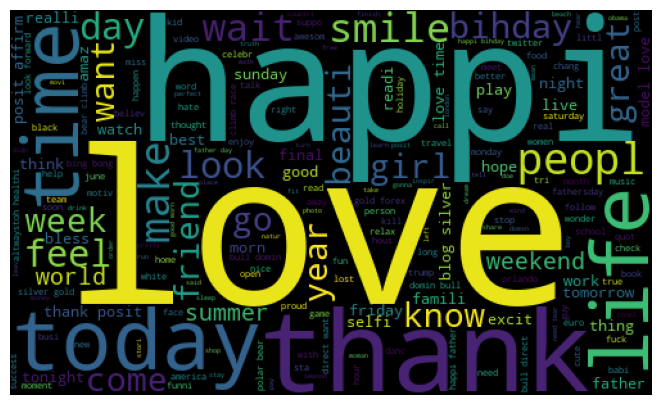

In [165]:
plt.figure(figsize= (10,5))
wordcloud = WordCloud(width =500, height= 300, random_state =0).generate(alltweets)
plt.imshow(wordcloud)
plt.savefig('wordcloud_output.png', bbox_inches='tight')
plt.axis('off');

## Common Words of Positive Comments

In [167]:
pos_tweets = ' '.join([ tw for tw in df['tweet_final'][df['label']==0]  ])
pos_tweets[:200]

'father dysfunct selfish drag kid dysfunct #run thank #lyft credit caus offer wheelchair van #disapoint #getthank bihday majesti #model love time factsguid societi #motiv huge fare talk leav chao dispu'

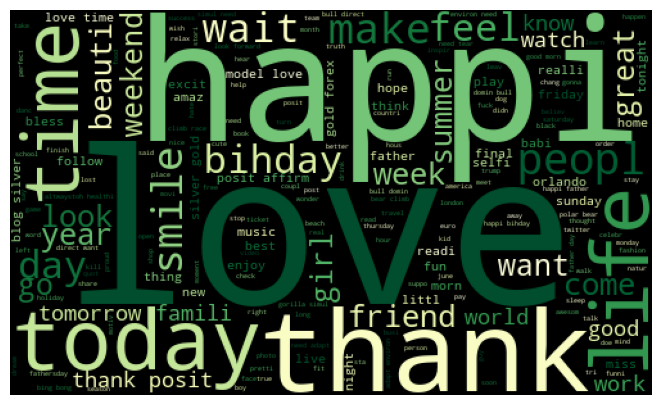

In [168]:
plt.figure(figsize= (10,5))
wordcloud = WordCloud(width =500, height= 300, colormap='YlGn', random_state =0).generate(pos_tweets)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud_outputpositive.png', bbox_inches='tight')

- Wordcloud of all tweets and wordclouds of positive tweets look like same. It is because of imbalance labels, let's check negative common words:

## Common words of Negative Comments

In [169]:
neg_tweets = ' '.join([ tw for tw in df['tweet_final'][df['label']==1] ])
neg_tweets[:200]

'#cnn call #michigan middl school build wall chant #tcot comment #australia #opkillingbay #seashepherd #helpcovedolphin #thecov #helpcovedolphin retweet agre lumpi say prove lumpi unbeliev centuri need'

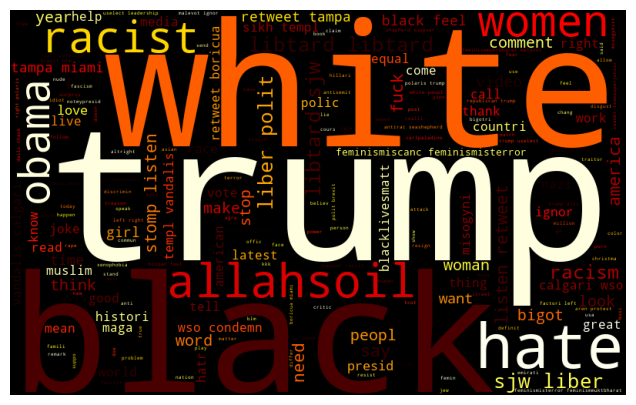

In [170]:
plt.figure(figsize= (10,5))
wordcloud = WordCloud(width =800, height= 500, colormap ='hot', random_state =0).generate(neg_tweets)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud_outputnegative.png', bbox_inches='tight')

- As we can see, the most common hate words are related to politics, racism, and holly religion.

## Extract Hashtag   

- In Twitter sentiment analysis, hashtags play a significant role in understanding the sentiment expressed in tweets. Hashtags are used by users to categorize and label their tweets, and they can be positive, negative, or neutral in sentiment.  
- Hashtags can provide context to the sentiment of a tweet. In the example, the negative hashtags are typically associated with negative sentiments, while the positive hashtags are associated with positive sentiments.   

- The number of positive or negative hashtags in a tweet can indicate the intensity of the sentiment. If a tweet includes multiple negative hashtags, it may represent strong negative sentiment, and the same goes for positive hashtags  
  
- We try to find hashtags by coding function. We are looking the words which come after #.  


In [171]:
# extract hashtag we apply this to clean tweet_final column
def extract_hashtag(tweets):
    h_list =[]
    for tw in tweets:
        h = re.findall('#(\w+)', tw)
        h_list.append(h)
    return h_list

In [172]:
pos_hashtag= extract_hashtag(df['tweet_final'][df['label']==0])
pos_hashtag[:10]

[['run'],
 ['lyft', 'disapoint', 'getthank'],
 [],
 ['model'],
 ['motiv'],
 ['allshowandnogo'],
 [],
 ['school', 'exam', 'hate', 'imagin', 'actorslif', 'revolutionschool', 'girl'],
 ['allin', 'cav', 'champion', 'cleveland', 'clevelandcavali'],
 []]

In [173]:
neg_hashtag= extract_hashtag(df['tweet_final'][df['label']==1])
neg_hashtag[:10]

[['cnn', 'michigan', 'tcot'],
 ['australia',
  'opkillingbay',
  'seashepherd',
  'helpcovedolphin',
  'thecov',
  'helpcovedolphin'],
 [],
 [],
 ['neverump', 'xenophobia'],
 ['love', 'peac'],
 [],
 ['race', 'ident', 'med'],
 ['altright', 'whitesupremaci'],
 ['linguist', 'race', 'power', 'raciolinguist']]

- Some tweets have more than one hasthags

In [174]:
#take them out of list of list.
pos_hashtag =sum(pos_hashtag, [])
neg_hashtag =sum(neg_hashtag, [])

In [175]:
pos_hashtag[:20]

['run',
 'lyft',
 'disapoint',
 'getthank',
 'model',
 'motiv',
 'allshowandnogo',
 'school',
 'exam',
 'hate',
 'imagin',
 'actorslif',
 'revolutionschool',
 'girl',
 'allin',
 'cav',
 'champion',
 'cleveland',
 'clevelandcavali',
 'ireland']

In [177]:
neg_hashtag[:20]

['cnn',
 'michigan',
 'tcot',
 'australia',
 'opkillingbay',
 'seashepherd',
 'helpcovedolphin',
 'thecov',
 'helpcovedolphin',
 'neverump',
 'xenophobia',
 'love',
 'peac',
 'race',
 'ident',
 'med',
 'altright',
 'whitesupremaci',
 'linguist',
 'race']

In [184]:
data = [[len(pos_hashtag), len(neg_hashtag)]]
df_hashtag = pd.DataFrame(data, columns=['positive', 'negative'], index=['Hashtag Number'])
df_hashtag

,positive,negative
Hashtag Number,68425,4616


## Frequency Distribution  
- It refers to a tabulation or listing of data values along with the number of times each value occurs in a dataset.

In [188]:
pos_freq =nltk.FreqDist(pos_hashtag)
pos_freq

FreqDist({'love': 1654, 'posit': 917, 'smile': 676, 'healthi': 573, 'thank': 534, 'fun': 463, 'life': 425, 'affirm': 423, 'summer': 390, 'model': 375, ...})

In [189]:
neg_freq =nltk.FreqDist(neg_hashtag)
neg_freq

FreqDist({'trump': 136, 'polit': 95, 'allahsoil': 92, 'liber': 81, 'libtard': 77, 'sjw': 75, 'retweet': 63, 'black': 46, 'miami': 46, 'hate': 37, ...})

In [190]:
df_pos= pd.DataFrame( {'hashtag': pos_freq.keys(), 'count': pos_freq.values()})
df_pos.head()

,hashtag,count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


In [191]:
df_neg= pd.DataFrame( {'hashtag':neg_freq.keys(), 'count': neg_freq.values()})
df_neg.head()

,hashtag,count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


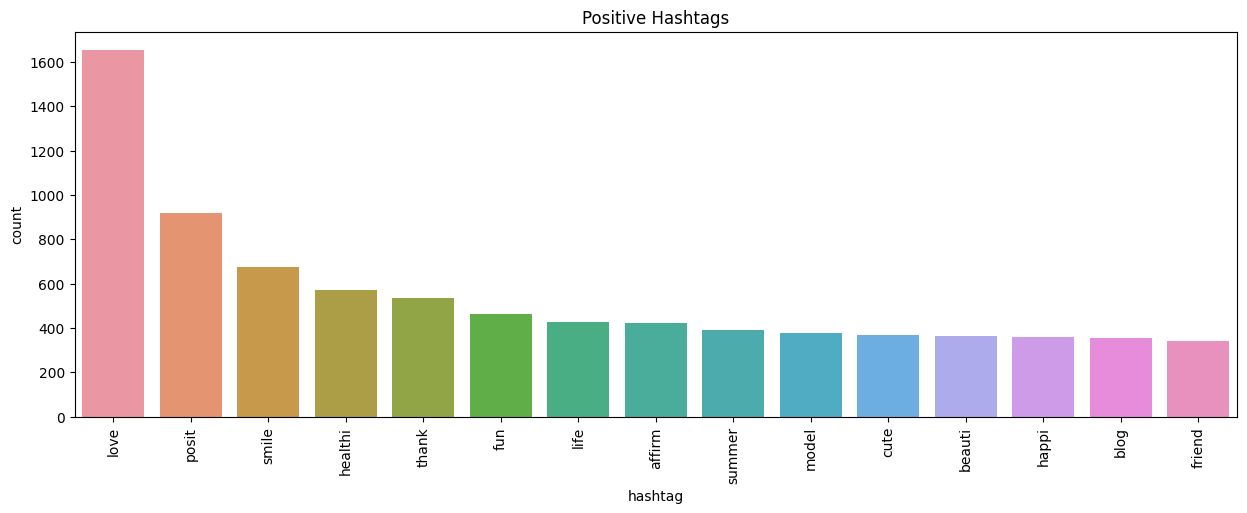

In [192]:
plt.figure(figsize=(15,5))
plt.title('Positive Hashtags')
plt.xticks(rotation=90)
sns.barplot(data =df_pos.nlargest(15, 'count'), x='hashtag' , y= 'count');

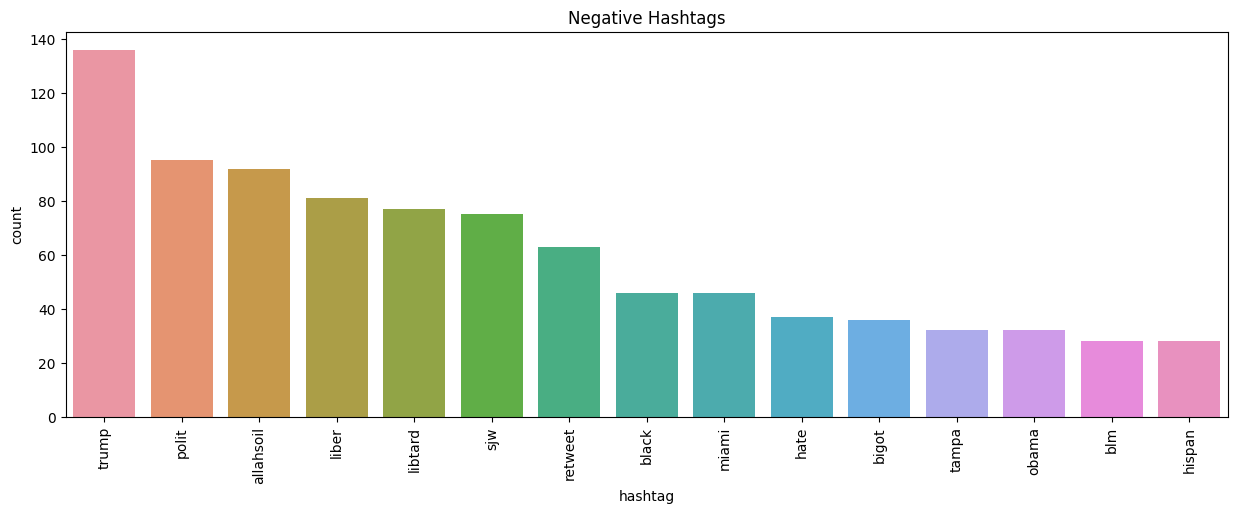

In [193]:
plt.figure(figsize=(15,5))
plt.title('Negative Hashtags')
plt.xticks(rotation=90)
sns.barplot(data =df_neg.nlargest(15, 'count'), x='hashtag' , y= 'count');

In [228]:
df.to_csv('dataset_nlp.csv', index=False)
df = pd.read_csv('dataset_nlp.csv')

In [ ]:
df = pd.read_csv('dataset_nlp.csv')

# Split the Data
- **Train and Test Data**

In [229]:
X_train,X_test,y_train,y_test = train_test_split(df['tweet_final'].values, df['label'].values, test_size=0.2, random_state=0)

In [230]:
X_train.shape, X_test.shape

((25569,), (6393,))

In [211]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [88]:
#max_df= 0.90       :  the words appears at most %90
#min_df= 2          : the words which appears in at least in two documents tweet
#max_features= 1000 : max number of features that we use

**Creating bag of words**

In [207]:
vect= CountVectorizer(max_df= 0.90,min_df= 2,max_features =1000, stop_words= 'english')
X_train_vect =vect.fit_transform(X_train)
X_test_vect =vect.transform(X_test)

In [204]:
X_train_vect#sparse matrix

<25569x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 94243 stored elements in Compressed Sparse Row format>

In [91]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Metric  
- Since I am working with imbalanced sentiment analysis datasets, accuracy may not provide a complete picture of the model's performance. The **F1 score** balances precision and recall, making it a suitable metric for overall performance evaluation. **The ROC Curve Score**, measured by AUC, is a valuable tool for assessing how well the model distinguishes between different sentiment classes, especially in situations where class distribution is imbalanced. These metrics together provide a more comprehensive assessment of model performance in sentiment analysis. I will use these two metrics to interpret my model.

# Building Model
## **Logistic Regression**

- Since the dimension is high because we have so many words in this case we just restricted to the 1000 which is still large number, so it is a good idea to use linear model. Since this is a classification question we will use Logistic Regression.

In [92]:
log_reg= LogisticRegression(max_iter= 1000)
log_reg.fit(X_train_vect, y_train)

LogisticRegression(max_iter=1000)

In [93]:
log_reg.score(X_train_vect, y_train), log_reg.score(X_test_vect, y_test)

(0.9544370135711213, 0.9519787267323635)

In [94]:
df['label'].value_counts()[0]/len(df)

0.9298542018647143

Accuracy score looks pretty good but as we know Logistic Regression is a sigmoid function and it classify the labels based on σ(z)≥0.5. Since this is imbalace data, we need to check Confusion Matrix and ROC Curve evaluation metrics. 

### Confusion Matrix & ROC Curve

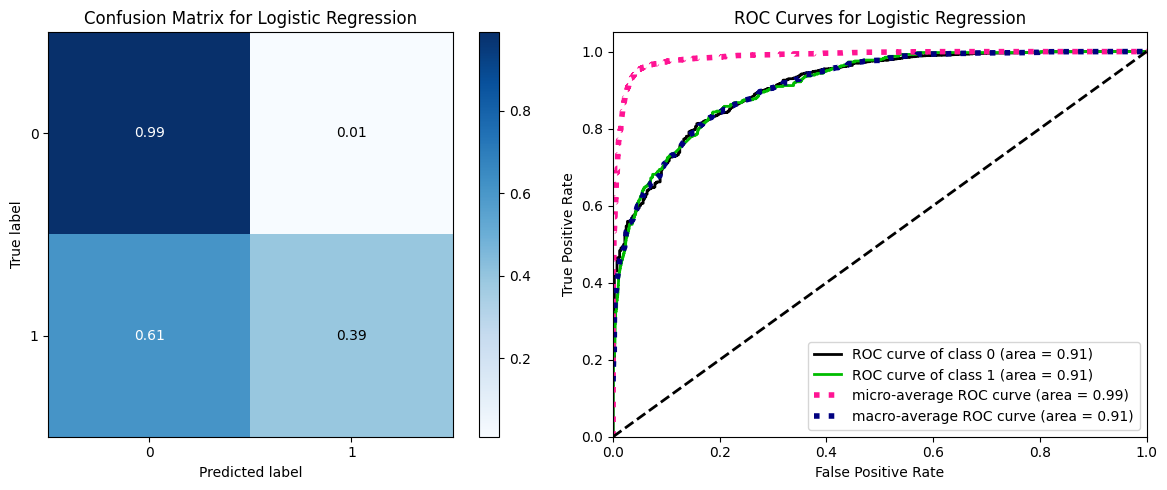

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
y_pred = log_reg.predict(X_test_vect)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression')

# ROC curve
y_proba = log_reg.predict_proba(X_test_vect)
skplt.metrics.plot_roc(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curves for Logistic Regression")

plt.tight_layout()
plt.show()

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5985
           1       0.73      0.39      0.51       408

    accuracy                           0.95      6393
   macro avg       0.84      0.69      0.74      6393
weighted avg       0.95      0.95      0.95      6393



- **Let's try another models**

## **Naive Bayes**
**MultinomialNB**

In [97]:
naive_bayes = MultinomialNB(class_prior =None)
naive_bayes.fit(X_train_vect, y_train)

nb_y_pred = naive_bayes.predict(X_test_vect)

print(f'Train Score: {naive_bayes.score(X_train_vect, y_train)}')
print(f'Test  Score: {naive_bayes.score(X_test_vect, y_test)}')
print('-'*70)
report = classification_report(y_test, nb_y_pred)
print(report)

Train Score: 0.9403574641167038
Test  Score: 0.9404035664007508
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5985
           1       0.54      0.50      0.52       408

    accuracy                           0.94      6393
   macro avg       0.75      0.74      0.74      6393
weighted avg       0.94      0.94      0.94      6393



**ComplementNB**

In [98]:
c_naive_bayes = ComplementNB()
c_naive_bayes.fit(X_train_vect, y_train)

cnb_y_pred = c_naive_bayes.predict(X_test_vect)

print(f'Train Score: {c_naive_bayes.score(X_train_vect, y_train)}')
print(f'Test  Score: {c_naive_bayes.score(X_test_vect, y_test)}')
print('-'*70)
report = classification_report(y_test, cnb_y_pred)
print(report)

Train Score: 0.8467284602448277
Test  Score: 0.8423275457531675
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5985
           1       0.26      0.77      0.38       408

    accuracy                           0.84      6393
   macro avg       0.62      0.81      0.65      6393
weighted avg       0.94      0.84      0.88      6393



### Confusion Matrix 

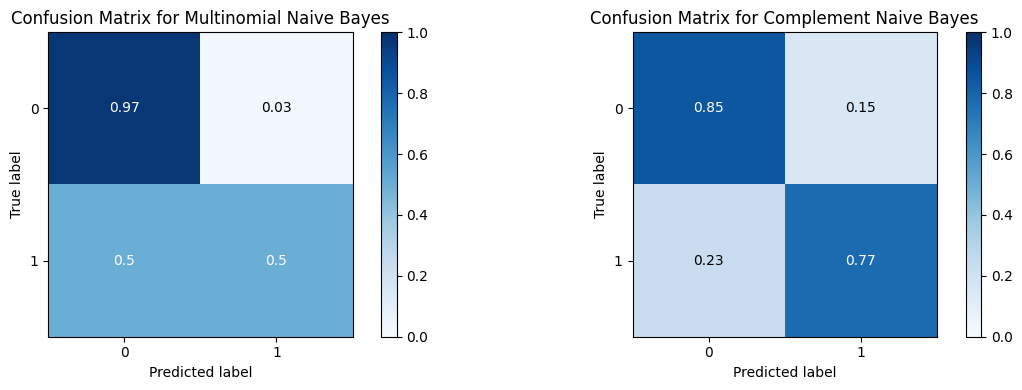

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Plot the first confusion matrix for Multinomial Naive Bayes
skplt.metrics.plot_confusion_matrix(y_test, nb_y_pred, normalize=True, ax=axes[0])

for im in axes[0].get_images():
    im.set_clim(0, 1) 
axes[0].set_title('Confusion Matrix for Multinomial Naive Bayes')

# Plot the second confusion matrix for Complement Naive Bayes
skplt.metrics.plot_confusion_matrix(y_test, cnb_y_pred, normalize=True, ax=axes[1])
# Remove the color bar from the second subplot
for im in axes[1].get_images():
    im.set_clim(0, 1)

axes[1].set_title('Confusion Matrix for Complement Naive Bayes')
plt.tight_layout()
plt.show()

Complement Naive Bayes Model increased the True Positive ,but on the other hand, it increased the False Positive and False Negative.

### NB ROC Curve 

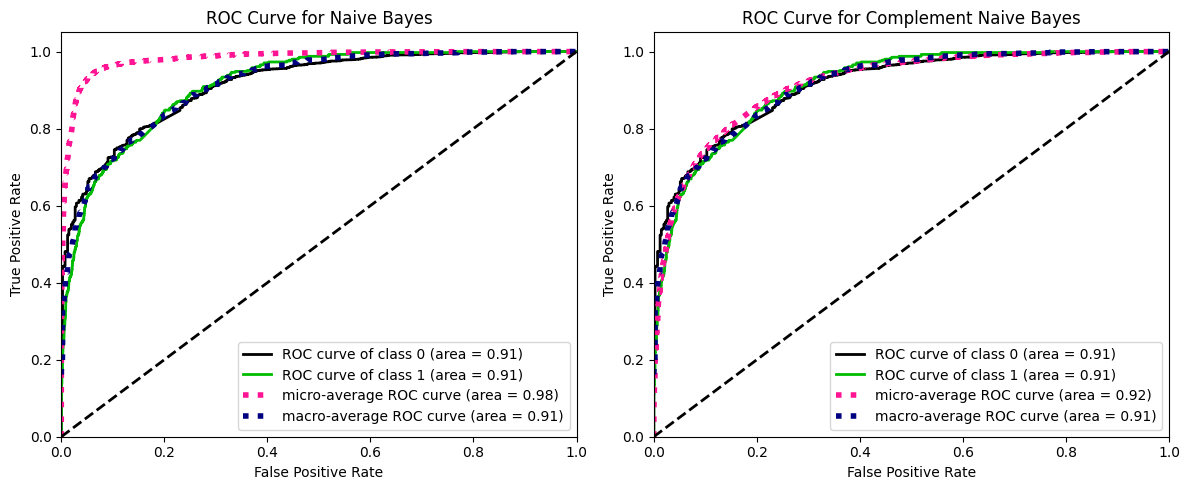

In [100]:
cnb_y_proba = c_naive_bayes.predict_proba(X_test_vect)
nb_y_proba  = naive_bayes.predict_proba(X_test_vect)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

skplt.metrics.plot_roc(y_test, nb_y_proba, ax=axes[0])
axes[0].set_title("ROC Curve for Naive Bayes")

skplt.metrics.plot_roc(y_test, cnb_y_proba, ax=axes[1])
axes[1].set_title("ROC Curve for Complement Naive Bayes")

plt.tight_layout()
plt.show()

- When we check the ROC curve, Multinomial Naive Bayes has a higher micro-average ROC curve score more than  Complement Naive Bayes model. In general, we can say Naive Bayes model's overall performance pretty nice in discriminating between classes. 

## **SVC**

- I did grid search and found the best parameters, but needed to run it again, so I just used the best params for second running instead. 

In [101]:
hyperparameters = {
    'C': 1,           
    'kernel': 'linear', 
    'gamma': 0.1,     
    'degree': 2,       
    'class_weight': None
}

svc = SVC(**hyperparameters)
svc.fit(X_train_vect, y_train)
sv_y_pred = svc.predict(X_test_vect)

accuracy = accuracy_score(y_test, sv_y_pred)
print(f'Accuracy: {accuracy:.2f}')

report = classification_report(y_test, sv_y_pred)
print(report)

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5985
           1       0.76      0.40      0.52       408

    accuracy                           0.95      6393
   macro avg       0.86      0.70      0.75      6393
weighted avg       0.95      0.95      0.95      6393



### Confusion Matrix & ROC Curve

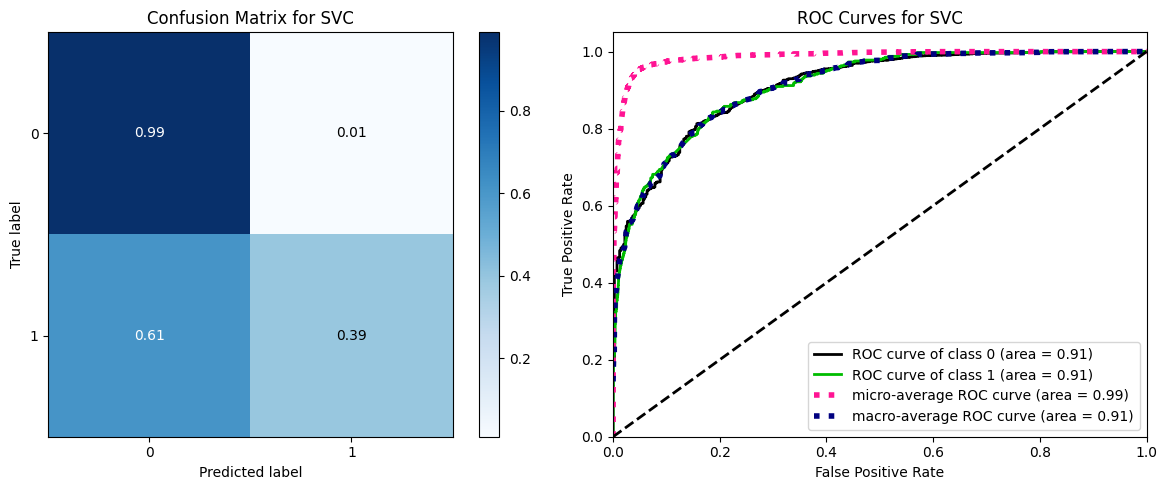

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Confusion matrix
sv_y_pred = log_reg.predict(X_test_vect)
skplt.metrics.plot_confusion_matrix(y_test, sv_y_pred, normalize=True, ax=axes[0])
axes[0].set_title('Confusion Matrix for SVC')
# ROC curve
y_proba = log_reg.predict_proba(X_test_vect)
skplt.metrics.plot_roc(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curves for SVC")
plt.tight_layout()
plt.show()

## **K-Nearest Neighbor**

In [103]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_vect, y_train)

knn_y_pred = knn.predict(X_test_vect)

print(f'Train Score: {knn.score(X_train_vect, y_train)}')
print(f'Test  Score: {knn.score(X_test_vect, y_test)}')

# Generate a classification report
report = classification_report(y_test, knn_y_pred)
print(report)

Train Score: 0.964840236223552
Test  Score: 0.9446269357109338
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5985
           1       0.60      0.38      0.47       408

    accuracy                           0.94      6393
   macro avg       0.78      0.68      0.72      6393
weighted avg       0.94      0.94      0.94      6393



### Confusion Matrix & ROC Curve

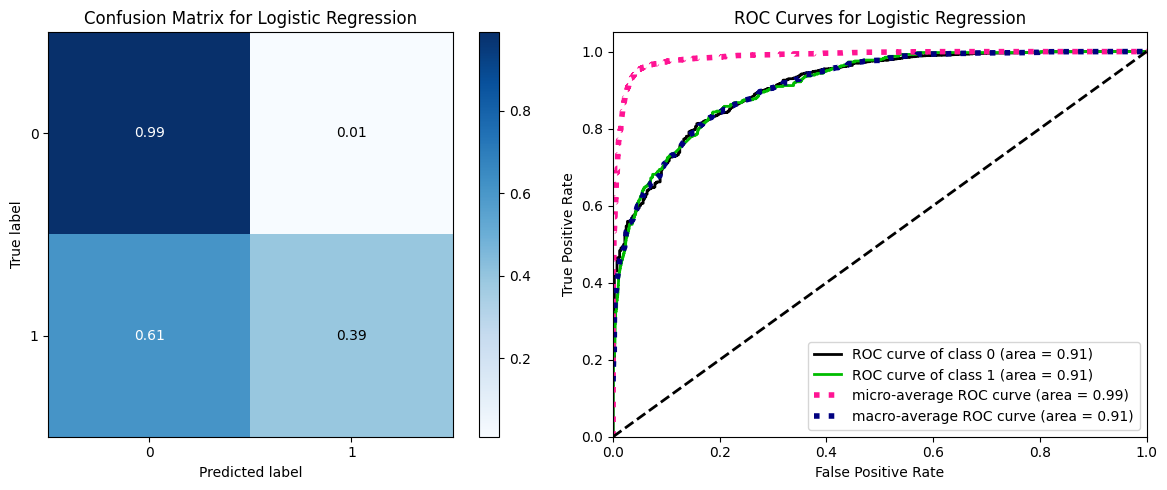

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Confusion matrix
knn_y_pred = log_reg.predict(X_test_vect)
skplt.metrics.plot_confusion_matrix(y_test, knn_y_pred, normalize=True, ax=axes[0])
axes[0].set_title('Confusion Matrix for Logistic Regression')

# ROC curve
y_proba = log_reg.predict_proba(X_test_vect)
skplt.metrics.plot_roc(y_test, y_proba, ax=axes[1])
axes[1].set_title("ROC Curves for Logistic Regression")

plt.tight_layout()
plt.show()

## **LSTM**  
- LSTM models are effective for Twitter sentiment analysis because they can capture the nuances, context, and sequential information present in tweets, enabling accurate sentiment classification. Let's try!

In [105]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

- Since I use LSTM, I will use the raw X_train instead of vectorized X_train_vect.

In [106]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100  # Set your desired sequence length
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


In [108]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [109]:
history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

Epoch 1/5
800/800 [==============================] - 144s 175ms/step - loss: 0.1608 - accuracy: 0.9484 - val_loss: 0.1142 - val_accuracy: 0.9611
Epoch 2/5
800/800 [==============================] - 140s 175ms/step - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.1194 - val_accuracy: 0.9651
Epoch 3/5
800/800 [==============================] - 137s 172ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.1382 - val_accuracy: 0.9646
Epoch 4/5
800/800 [==============================] - 121s 151ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.1628 - val_accuracy: 0.9601
Epoch 5/5
800/800 [==============================] - 136s 170ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.1980 - val_accuracy: 0.9596


### Confusion Matrix & ROC Curve

200/200 [==============================] - 7s 37ms/step


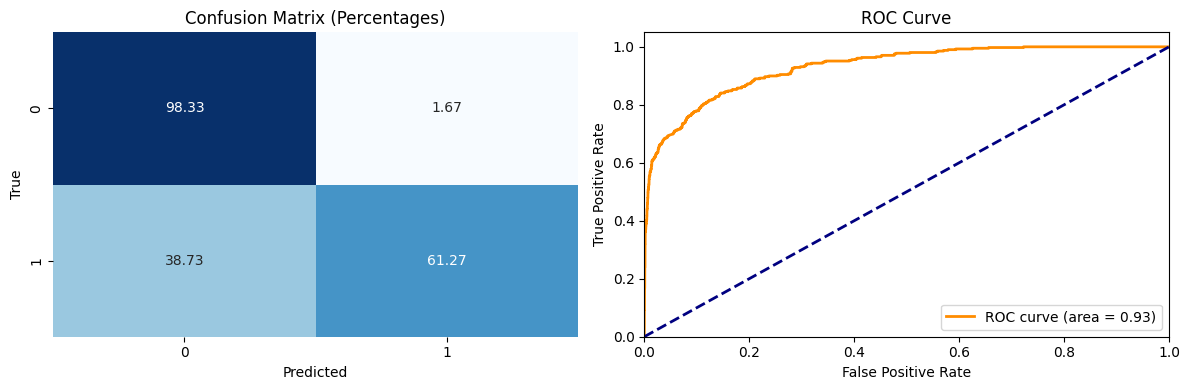

In [115]:
# Make predictions on the test data
y_pred = model.predict(X_test_padded)
lstm_y_pred = (y_pred > 0.5).astype(int)# Convert the probability predictions to binary predictions

confusion = confusion_matrix(y_test, y_pred_binary)
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Normalize the confusion matrix to percentages
confusion_percentage = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Percentages)")

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

_**Classes:**_  
**0 :  Not Racist/ sexist**   
**1 :  Racist/ sexist**

In [116]:
y_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

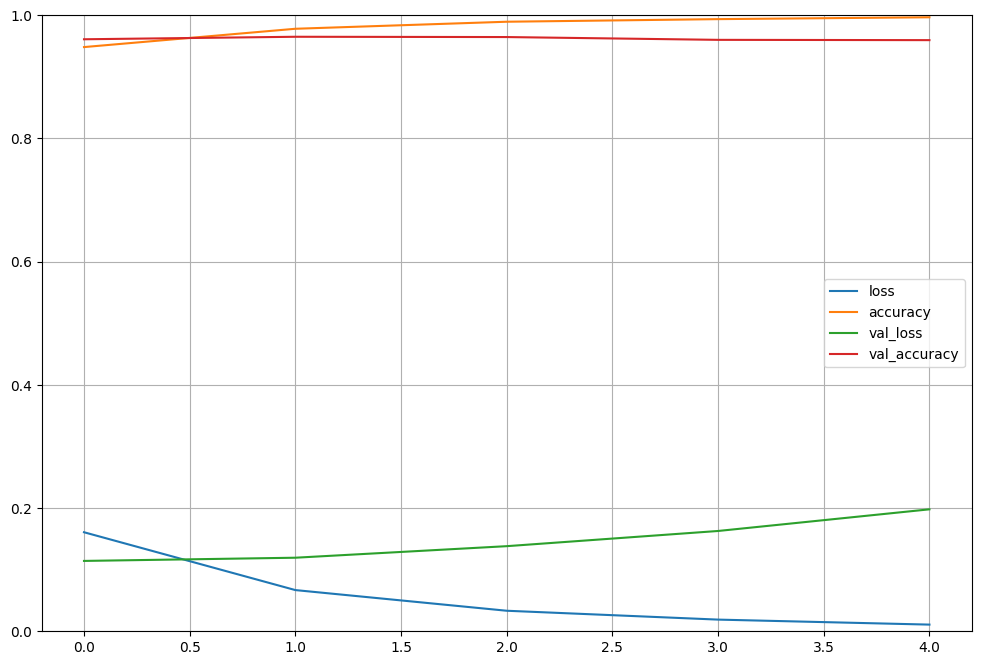

In [199]:
pd.DataFrame(history.history).plot(figsize = (12, 8))
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [117]:
# Generate the classification report
report = classification_report(y_test, lstm_y_pred, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5985
           1       0.71      0.61      0.66       408

    accuracy                           0.96      6393
   macro avg       0.84      0.80      0.82      6393
weighted avg       0.96      0.96      0.96      6393



In [7]:
model.save('twitter_Sent_model_lstm.h5')

# Conclusion 

- During this sentiment analysis process firstly, I tried to understand insight of tweets.By extracting,  I wanted to see the the relationship between the hashtags and tweets. And we observed which hashtag is used most. After understand the data I applied the Linear model which is logistic Regression, tree based model which is XGBoost, Support Vector Classifier, KNN  and Neural Network model which is LSTM. I got the best result with LSTM but this F1 score still did not satisfied me. That is why I checked the ROC curves. I noticed all the models distinguish the classes well. 